# 필요한 모듈 설정

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import patches
%matplotlib inline

# 데이터 로드

In [2]:
wine = pd.read_csv('WineQT.csv')
wine.drop(["Id"],axis=1, inplace=True) # 필요없는 'Id' column 제거
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 데이터 크기, 결측치 확인

# Modeling 

## Scaled, Normalization

In [33]:
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 

oversample = SMOTE()
features, labels =  oversample.fit_resample(wine.drop(["quality"],axis=1), wine["quality"])

scaler = preprocessing.MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
#scaled_data

In [34]:
normalized_arr = preprocessing.normalize(scaled_data)
normalized_data = pd.DataFrame(normalized_arr, columns=features.columns)
#normalized_data

In [5]:
from numpy import log
import warnings
warnings.filterwarnings(action='ignore')
unskew_data = normalized_data.copy(deep=True)

## Classifier Models

In [6]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn import metrics

## train / test split

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(unskew_data, labels, test_size=0.2, random_state=42)

In [7]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

In [8]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, 'r-', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시

In [9]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*20 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

In [10]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

In [11]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

In [12]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

In [45]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
         model = algorithm(random_state=1234, 
                           min_samples_leaf = n_leaf,
                           min_samples_split = n_split, 
                           max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    #print(f"Precision: {precision_score(y_test, y_pred):.3f}", average = "macro") # 정밀도
    #print(f"Recall: {recall_score(y_test, y_pred):.3f}", average = "macro") # 재현율
    #print(f"F1-score: {f1_score(y_test, y_pred):.3f}", average = "macro") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['Red', 'White'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름

In [14]:
algorithm = RandomForestClassifier
algorithm_name = 'rfc'

In [17]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도: 1.0
테스트 데이터셋 정확도: 0.866


     n_estimators  TrainScore  TestScore
0              20      0.9991     0.8397
1              40      1.0000     0.8431
2              60      1.0000     0.8517
3              80      1.0000     0.8517
4             100      1.0000     0.8603
..            ...         ...        ...
195          3920      1.0000     0.8724
196          3940      1.0000     0.8724
197          3960      1.0000     0.8724
198          3980      1.0000     0.8724
199          4000      1.0000     0.8724

[200 rows x 3 columns]


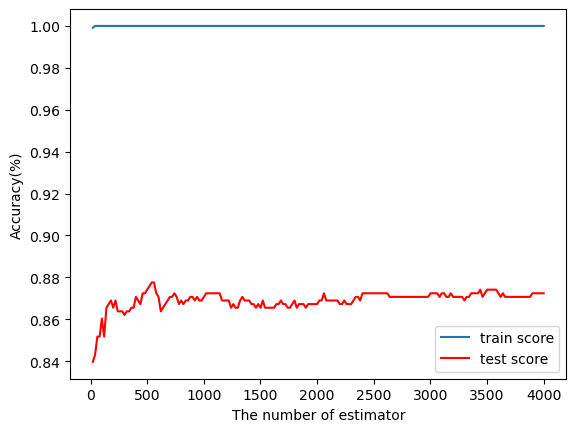

In [34]:
n_estimator_min = 1
n_estimator_max = 201
optimi_estimator(algorithm, algorithm_name, 
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

   n_estimators  TrainScore  TestScore
0            20      0.9991     0.8397
1            40      1.0000     0.8431
2            60      1.0000     0.8517
3            80      1.0000     0.8517
4           100      1.0000     0.8603
5           120      1.0000     0.8517
6           140      1.0000     0.8655
7           160      1.0000     0.8672
8           180      1.0000     0.8690
9           200      1.0000     0.8655


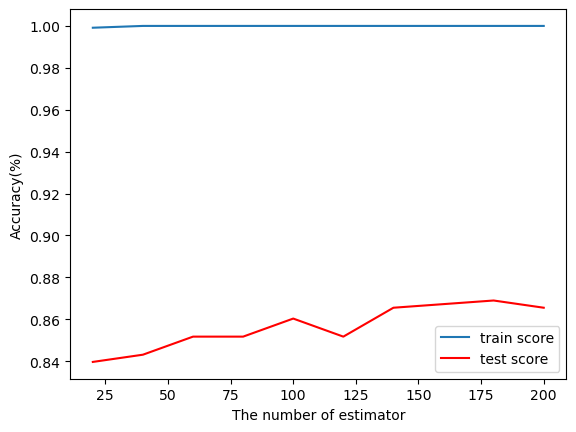

In [33]:
n_estimator_min = 1
n_estimator_max = 11
optimi_estimator(algorithm, algorithm_name, 
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

In [35]:
n_estimator = 600

    depth  TrainScore  TestScore
0       1      0.4021     0.3828
1       2      0.5142     0.4741
2       3      0.5858     0.5500
3       4      0.6773     0.6103
4       5      0.7597     0.6897
5       6      0.8326     0.7293
6       7      0.9047     0.7983
7       8      0.9469     0.8241
8       9      0.9797     0.8293
9      10      0.9909     0.8414
10     11      0.9974     0.8466
11     12      0.9983     0.8672
12     13      0.9987     0.8707
13     14      1.0000     0.8655
14     15      1.0000     0.8621
15     16      1.0000     0.8655
16     17      1.0000     0.8638
17     18      1.0000     0.8655
18     19      1.0000     0.8655
19     20      1.0000     0.8655
20     21      1.0000     0.8638
21     22      1.0000     0.8569
22     23      1.0000     0.8655
23     24      1.0000     0.8655
24     25      1.0000     0.8638
25     26      1.0000     0.8655
26     27      1.0000     0.8638
27     28      1.0000     0.8638
28     29      1.0000     0.8638
29     30 

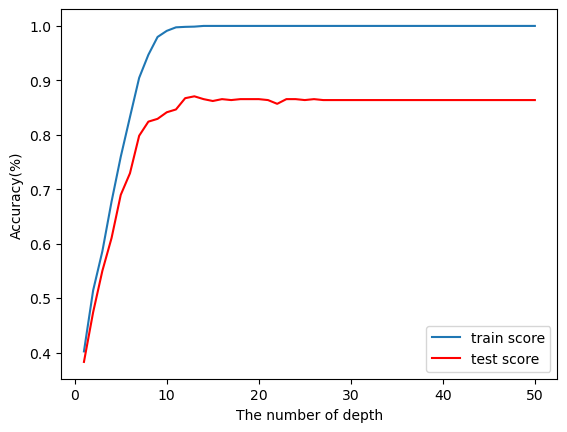

In [32]:
depth_min = 1
depth_max = 51
optimi_maxdepth(algorithm, algorithm_name, 
                x_train, y_train, x_test, y_test, 
                depth_min, depth_max, n_estimator)

    depth  TrainScore  TestScore
0       1      0.4021     0.3828
1       2      0.5142     0.4741
2       3      0.5858     0.5500
3       4      0.6773     0.6103
4       5      0.7597     0.6897
..    ...         ...        ...
95     96      1.0000     0.8638
96     97      1.0000     0.8638
97     98      1.0000     0.8638
98     99      1.0000     0.8638
99    100      1.0000     0.8638

[100 rows x 3 columns]


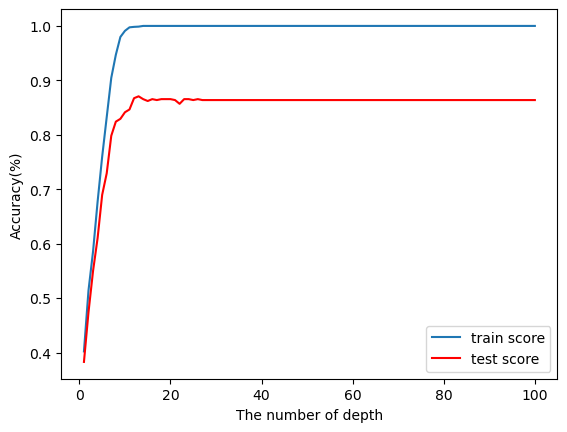

In [22]:
depth_min = 1
depth_max = 101
optimi_maxdepth(algorithm, algorithm_name, 
                x_train, y_train, x_test, y_test, 
                depth_min, depth_max, n_estimator)

In [23]:
n_depth = 18

    min_samples_split  TrainScore  TestScore
0                   2      1.0000     0.8569
1                   4      1.0000     0.8690
2                   6      0.9996     0.8569
3                   8      0.9953     0.8586
4                  10      0.9922     0.8621
5                  12      0.9845     0.8586
6                  14      0.9763     0.8534
7                  16      0.9664     0.8397
8                  18      0.9607     0.8362
9                  20      0.9551     0.8345
10                 22      0.9461     0.8224
11                 24      0.9357     0.8259
12                 26      0.9271     0.8276
13                 28      0.9215     0.8172
14                 30      0.9137     0.8138
15                 32      0.9072     0.8103
16                 34      0.8986     0.7983
17                 36      0.8900     0.8017
18                 38      0.8861     0.7897
19                 40      0.8831     0.7845
20                 42      0.8745     0.7879
21        

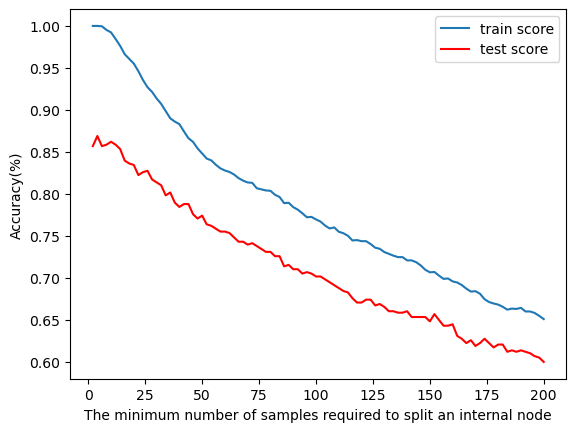

In [24]:
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

In [36]:
n_depth = 18

    min_samples_split  TrainScore  TestScore
0                   2      0.9983     0.8672
1                   4      0.9978     0.8621
2                   6      0.9961     0.8655
3                   8      0.9914     0.8466
4                  10      0.9840     0.8483
5                  12      0.9771     0.8466
6                  14      0.9681     0.8379
7                  16      0.9594     0.8362
8                  18      0.9543     0.8328
9                  20      0.9461     0.8293
10                 22      0.9379     0.8172
11                 24      0.9297     0.8190
12                 26      0.9206     0.8138
13                 28      0.9142     0.8086
14                 30      0.9098     0.8034
15                 32      0.9051     0.8034
16                 34      0.8947     0.7931
17                 36      0.8874     0.7966
18                 38      0.8805     0.7897
19                 40      0.8762     0.7879
20                 42      0.8697     0.7845
21        

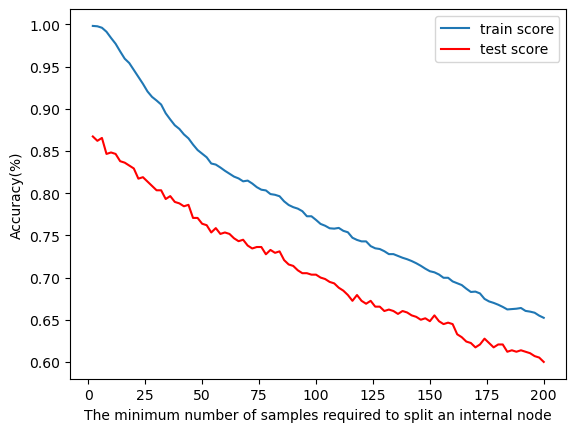

In [26]:
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

In [41]:
n_split = 2

    min_samples_leaf  TrainScore  TestScore
0                  2      0.9957     0.8534
1                  4      0.9625     0.8328
2                  6      0.9392     0.8276
3                  8      0.9124     0.8086
4                 10      0.8891     0.8000
5                 12      0.8697     0.7897
6                 14      0.8494     0.7793
7                 16      0.8365     0.7448
8                 18      0.8266     0.7466
9                 20      0.8097     0.7328
10                22      0.8050     0.7241
11                24      0.7985     0.7293
12                26      0.7903     0.7190
13                28      0.7761     0.7138
14                30      0.7675     0.6948
15                32      0.7593     0.6862
16                34      0.7524     0.6845
17                36      0.7420     0.6810
18                38      0.7386     0.6724
19                40      0.7304     0.6638
20                42      0.7248     0.6586
21                44      0.7200

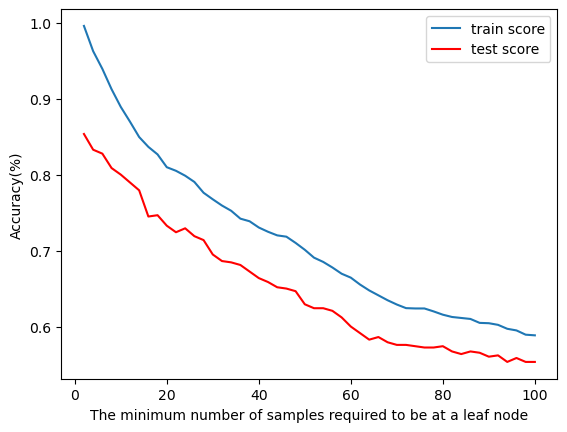

In [28]:
n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               x_train, y_train, x_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

In [42]:
n_leaf = 1

In [43]:
# 설명변수 선정
x = wine[wine.columns.difference(['target'])]
# 설명변수명 리스트
feature_name = x.columns


Accuracy: 0.866


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (2).

<Figure size 3000x3000 with 0 Axes>

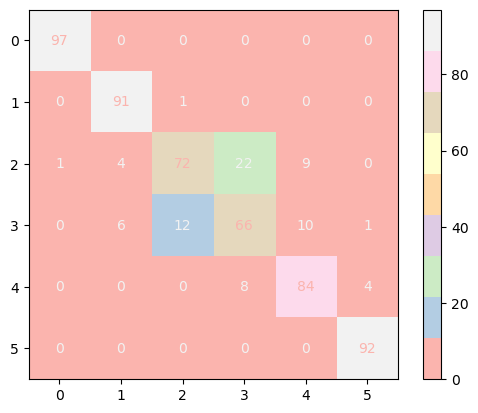

In [47]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
model_final(algorithm, algorithm_name, feature_name,
            x_train, y_train, x_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)